## Name:Rakesh Paul
    
## Student ID:22271872

## Task2 
In this task, we aim at training a regression model for predicting the `insurance_cost` of a person from its other characteristics.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import FastICA

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

We start with a brief EDA to check for missing values and outliers.

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Let's examine values in the categorical columns.

In [4]:
categorical_attributes = df.select_dtypes(include=['object']).columns.tolist()

for categorical in categorical_attributes:
    print("\nAttribute: ", categorical)
    print(df[categorical].value_counts())


Attribute:  gender
male      676
female    662
Name: gender, dtype: int64

Attribute:  smoker
no     1064
yes     274
Name: smoker, dtype: int64

Attribute:  region
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


Now, let's check for missing values and outliers.

In [5]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [6]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

They all look OK

Next, let's check for outliers in the numerical columns. Based on the table above we can try to plot all numerical column except `insurance_cost` together.

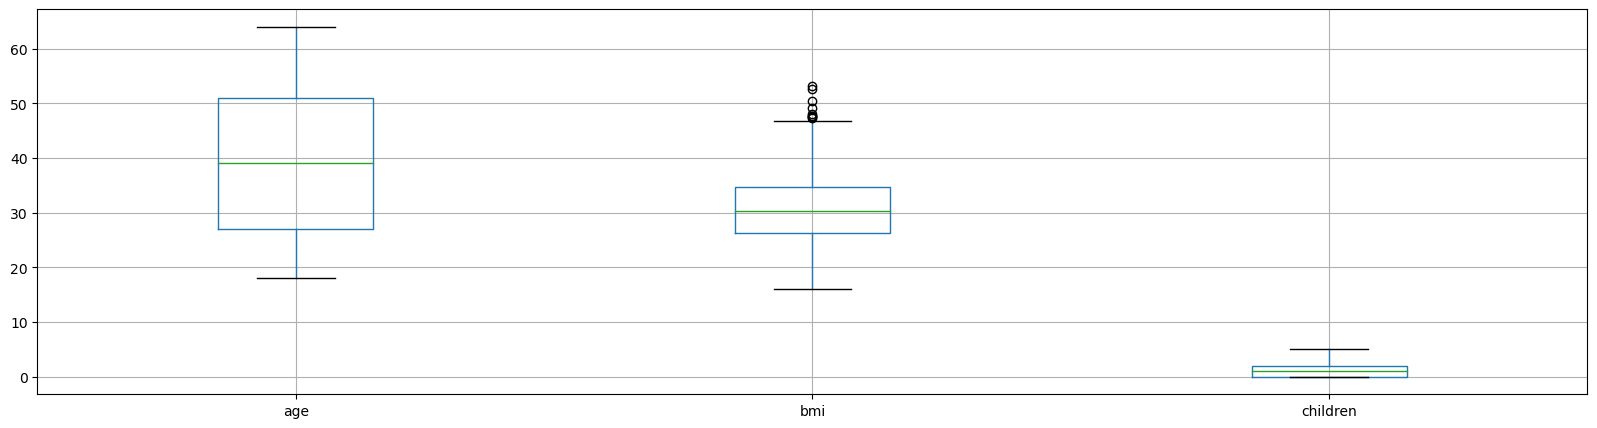

In [7]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

- There are quite some outliers in `bmi` attribute with the default settings for the boxplot function. We apply `RobustScaler`  followed by log transform for the `bmi`.
- Other attributes dont have outlier. We apply `StandardScaler` to rescale these attributes.

## Data Preparation
### Categorical attribute

Next, we will replace the categorical columns `gender`, `smoker`, and `region` by one-hot encoding because they are nominal categorical attribute.

In [8]:
# Before converting categorical features to numerical, copy the actual numeric feature names
numerical_attributes = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_attributes

['age', 'bmi', 'children', 'insurance_cost']

In [9]:
df = pd.get_dummies(df, columns=categorical_attributes, 
                        #dummy_na=True, 
                        drop_first=True)

Let's examine the transformed dataset.

In [10]:
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

In [11]:
df.tail()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
1333   64  31.825         2     16069.08475            0           0   
1334   64  26.885         0     29330.98315            0           1   
1335   64  26.410         0     14394.55790            1           0   
1336   64  36.960         2     49577.66240            1           1   
1337   64  23.760         0     26926.51440            1           1   

      region_northwest  region_southeast  region_southwest  
1333                 0                 0                 0  
1334                 1                 0                 0  
1335                 0                 0                 0  
1336                 0                 1                 0  
1337                 0                 1                 0

### Numerical Attributes

In [12]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]

# define column groups with same data preparation
names_outliers = ['bmi']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [13]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [14]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [15]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [16]:
pipe_rf = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [17]:
N_FEATURES_OPTIONS = [2, 5, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search_rf = GridSearchCV(pipe_rf, param_grid, n_jobs=-1, cv=5, refit=True)

The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [18]:
pipe_lr = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [19]:
N_FEATURES_OPTIONS = [2, 5, 8]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    }  
]

search_lr = GridSearchCV(pipe_lr, param_grid, n_jobs=-1, cv=5, refit=True)

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [20]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [21]:
def ExecuteModel(model, X, y, name, num_runs=10):

    # Initialize the lists to store the evaluation metrics for each run
    mse_list = []
    mae_list = []
    r2_list = []

    best_model = None
    best_score = -np.inf
    best_params = None

    for i in range(num_runs):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

        model.fit(X_train, y_train) 
        
        score = model.best_score_
        if score > best_score:
            best_params = model.best_params_
            best_score = score

            best_model = model.best_estimator_

        mse, mae, r2 = evaluate_model(X_test, y_test, model.best_estimator_)

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        
    print("Best CV score = %0.3f:" % model.best_score_)
    print("Best parameters: ", model.best_params_)

    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average", name, f" MSE: {avg_mse:.3f}")
    print(f"Average", name, f" MAE: {avg_mae:.3f}")
    print(f"Average", name, f" R2: {avg_r2:.3f}")

    return avg_mse, avg_mae, avg_r2, best_params

We will use the ExecuteModel() function to train and evaluate the best Random Forest and Linear Regression models found by the grid search.

In [22]:
RF_mse, RF_mae, RF_r2, RF_best_params = ExecuteModel(search_rf, X, y, "Random Forest")

LR_mse, LR_mae, LR_r2, LR_best_params = ExecuteModel(search_lr, X, y, "Linear Regression")

Best CV score = 0.851:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5, 'regression__max_depth': 4}
Average Random Forest  MSE: 16813300.801
Average Random Forest  MAE: 2362.596
Average Random Forest  R2: 0.881
Best CV score = 0.748:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5}
Average Linear Regression  MSE: 36168023.064
Average Linear Regression  MAE: 4377.614
Average Linear Regression  R2: 0.744


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

We will use a Pandas bar plots to compare the results. 

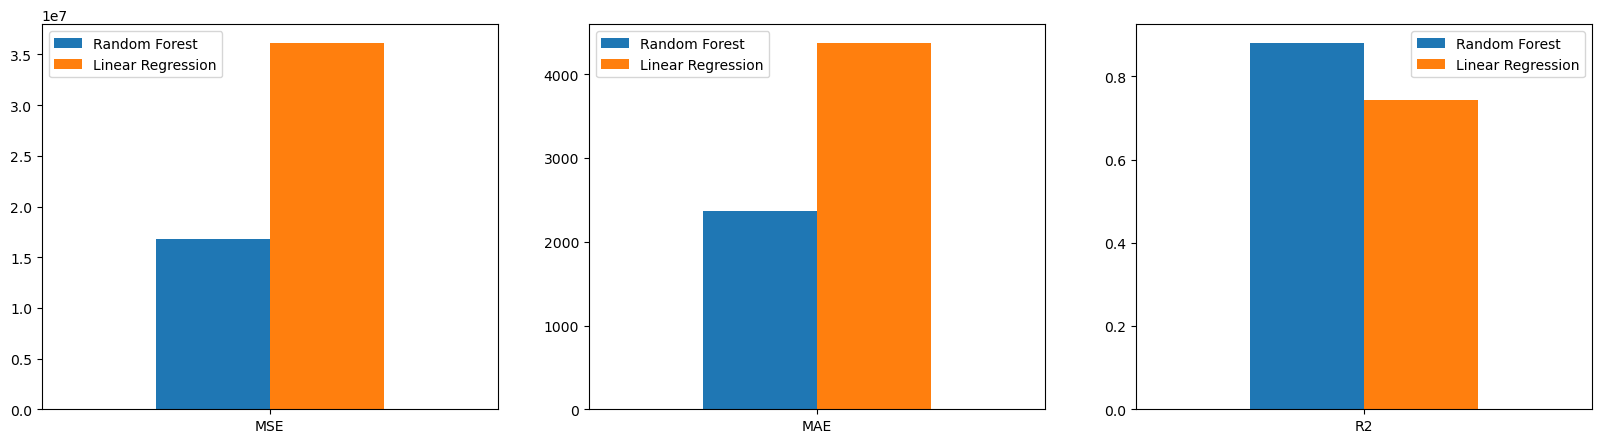

In [23]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

## Train another regression model
### Decision Tree regression Pipeline

In [24]:
pipe_dr = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', DecisionTreeRegressor())])

In [25]:
MIN_SAMPLES_SPLIT = [2, 5, 10, 20]
MAX_DEPTH_OPTIONS = [2, 4, 6]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__min_samples_leaf': MIN_SAMPLES_SPLIT
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__min_samples_leaf': MIN_SAMPLES_SPLIT
    }  
]

search_dr = GridSearchCV(pipe_dr, param_grid, n_jobs=-1, cv=5, refit=True)

We will use the ExecuteModel() function to train and evaluate the Decision tree Regression model with hyperparameter combinations found by the grid search.

In [26]:
DR_mse, DR_mae, DR_r2, DR_best_params = ExecuteModel(search_dr, X, y, "Decision Tree")

Best CV score = 0.847:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5, 'regression__max_depth': 4, 'regression__min_samples_leaf': 20}
Average Decision Tree  MSE: 17601870.824
Average Decision Tree  MAE: 2496.462
Average Decision Tree  R2: 0.875


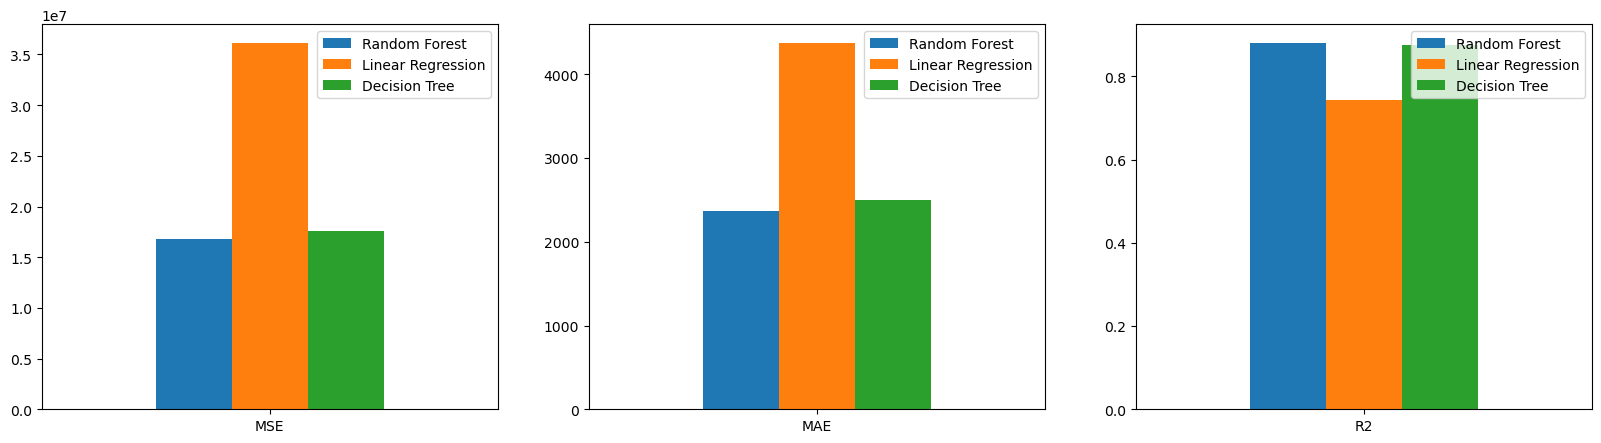

In [27]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Decision Tree': DR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Decision Tree': DR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Decision Tree': DR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### Comparison
Random Forest Regressor gave the lowest MSE and MAE, indicating lowest error in prediction. It has the highest R2 score meaning that it can explain a significant proportion of variance in the target (`insurance_cost`). 

Linear Regression gave highest MAE and MSE than Random Forest and Decison Tree, indicating highest error in prediction for the dataset. It also has the lowest R2 score which means the model can explain only relatively small proportion of variance in target variable. This suggests that Linear regression model is the least accurate and reliable method for predicting the target.

Decision Tree Regressor gives higher MAE and MSE compare Random Forest but much less than Linear Regression, indicating higher error in prediction compared to Random Forest regression. Also it has a relatively high R2 score than Linear regression (almost near to Random Forest), indicating that it can explain a significant proportion of the variance in the target variable. While the decision tree regression model is less accurate than the random forest model, it can still provide useful insights into the relationship between the independent variables and target attribute.

Cross-validation score reflects the average performance of the model across multiple runs, and can be used to estimate the generalization performance of the model on new, unseen data. The Random Forest Regressor has a higher cross-validation score (0.851) than the Decision Tree Regression (0.847) and Linear Regression (0.748). It indicate that the Random Forest Regressor is better able to capture the underlying data patterns and produce more accurate predictions on new data. Even though overall performance of Random forest regressor and decision tree regressor are almost similar, the memory requirement of the former is more.

Overall, random forest regressor is best for predicting `insurance_cost` on this dataset, followed by decision tree regression and then linear regressor.

## Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [28]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [29]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Task 3

We can use the following dimentionality reduction algorithm which are different from the already used ones:
- LLE (Locally Linear Embedding): This is a non-linear dimensionality reduction technique that seeks to preserve the local linear structure of the data. 
- Fast Independent Component Analysis (FastICA): FastICA is a linear dimensionality reduction algorithm that aims to find a linear transformation of the data that maximizes the independence of the components.

### Update Pipelines:
#### Random Forest pipeline

In [30]:
N_COMPONENTS_OPTIONS = [2, 3, 4]
MAX_DEPTH_OPTIONS = [2, 4, 6]

param_grid = [
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_COMPONENTS_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search_rf_new = GridSearchCV(pipe_rf, param_grid, n_jobs=-1, cv=5, refit=True)

We will use the ExecuteModel() function to train and evaluate the Random Forest Regression model with LocallyLinearEmbedding() and  FastICA() dimensionality-reduction techniques.

In [31]:
RF_mse_new, RF_mae_new, RF_r2_new, RF_best_params_new = ExecuteModel(search_rf_new, X, y, "Random Forest")

C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Sta

Best CV score = 0.604:
Best parameters:  {'reduce_dim': FastICA(n_components=4), 'reduce_dim__n_components': 4, 'regression__max_depth': 6}
Average Random Forest  MSE: 48985395.910
Average Random Forest  MAE: 4738.643
Average Random Forest  R2: 0.653


C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


#### Linear Regression pipeline

In [32]:
N_FEATURES_OPTIONS = [2, 3]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FastICA()],
        
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }  
]

search_lr_new = GridSearchCV(pipe_lr, param_grid, n_jobs=-1, cv=5, refit=True)

We will use the ExecuteModel() function to train and evaluate the Linear Regression model with LocallyLinearEmbedding() and  FastICA() dimensionality-reduction techniques.

In [33]:
LR_mse_new, LR_mae_new, LR_r2_new, LR_best_params_new = ExecuteModel(search_lr_new, X, y, "Linear Regression")

C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Sta

Best CV score = 0.302:
Best parameters:  {'reduce_dim': FastICA(n_components=3), 'reduce_dim__n_components': 3}
Average Linear Regression  MSE: 100294099.503
Average Linear Regression  MAE: 7814.235
Average Linear Regression  R2: 0.290


C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


#### Decision tree pipeline

In [34]:
MIN_SAMPLES_SPLIT = [2, 5, 10, 20]
N_FEATURES_OPTIONS = [2, 3]
MAX_DEPTH_OPTIONS = [2, 4, 6]

param_grid = [
    {
        'reduce_dim': [LocallyLinearEmbedding()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__min_samples_leaf': MIN_SAMPLES_SPLIT
    },
    {
        'reduce_dim': [FastICA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__max_depth': MAX_DEPTH_OPTIONS,
        'regression__min_samples_leaf': MIN_SAMPLES_SPLIT
    }  
]

search_dr_new = GridSearchCV(pipe_dr, param_grid, n_jobs=-1, cv=5, refit=True)

We will use the ExecuteModel() function to train and evaluate the Decision tree Regression model with LocallyLinearEmbedding() and  FastICA() dimensionality-reduction techniques.

In [35]:
DR_mse_new, DR_mae_new, DR_r2_new, DR_best_params_new = ExecuteModel(search_dr_new, X, y, "Decision Tree")

C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\sneha\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Best CV score = 0.523:
Best parameters:  {'reduce_dim': LocallyLinearEmbedding(n_components=3), 'reduce_dim__n_components': 3, 'regression__max_depth': 6, 'regression__min_samples_leaf': 5}
Average Decision Tree  MSE: 75046582.910
Average Decision Tree  MAE: 6199.598
Average Decision Tree  R2: 0.469


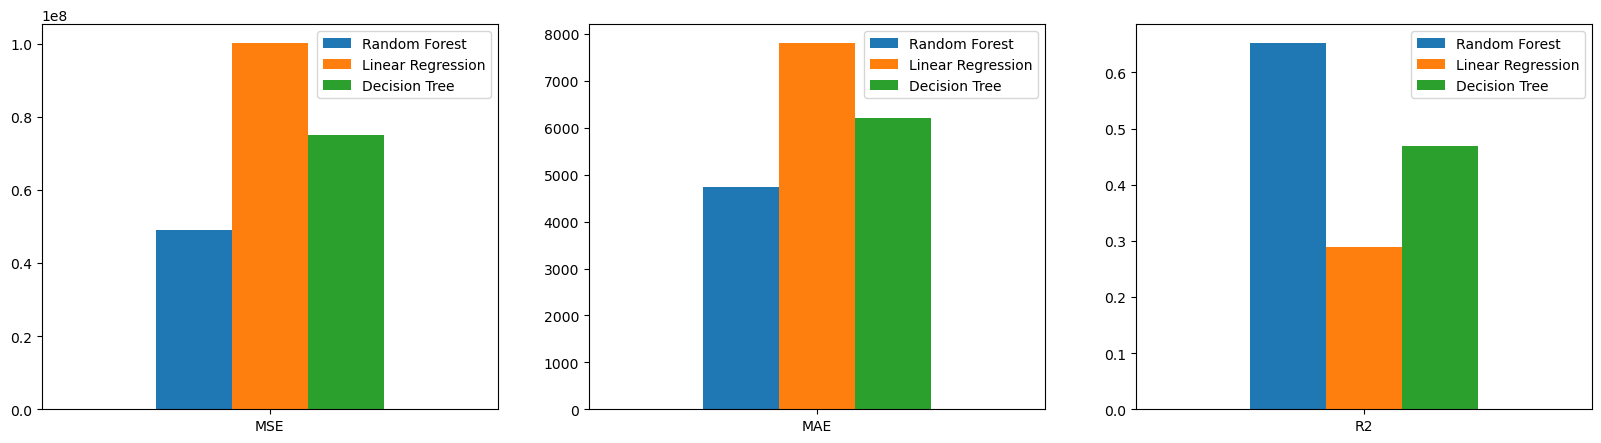

In [36]:
df_mse = pd.DataFrame({'Random Forest': RF_mse_new, 'Linear Regression': LR_mse_new, 'Decision Tree': DR_mse_new}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae_new, 'Linear Regression': LR_mae_new, 'Decision Tree': DR_mae_new}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2_new, 'Linear Regression': LR_r2_new, 'Decision Tree': DR_r2_new}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

#### Observation
In this task I have used 2 new dimensionality reduction algorithms LLE and FastICA. THey are significantly different from PCA and RFE in their underlying assumptions and mathematical methods.

- PCA (Principal Component Analysis) and RFE (Recursive Feature Elimination) can be considered parametric in the sense that they rely on a set of assumptions about the distribution of the data and the relationship between the variables.

- LLE and FastICA are non-linear and non-parametric methods that seek to preserve local structure or identify independent sources of variatiocore
Comparitive analysis of MSE, MAE, R2 and CV score shows same relative performance where Random Forest regressor performs best followed by Decision Tree regressor, which in followed by Linear regression. But, the CV score has drastically reduced when using LLE and FastICA for all the regression algorithm used here (upto more than 50% reduction). Also, Decision tree regressor has performed much worse than Random forest regressor.

Dimensionality reduction algorithms can impact the performance of Random Forest regression, Linear regression, and Decision Tree regression in several ways:
- Complexity reduction : Dimensionality reduction can simplify the input data by removing redundant or irrelevant features, which can reduce the complexity of the models and improve their performance. 
- Interpretability: Dimensionality reduction can also improve the interpretability of the models by reducing the number of features and making the relationships between them more explicit. 

Overall, the impact of dimensionality reduction on the performance of the models depends on several factor like features of the data, the choice of dimensionality reduction algorithm, and the choice of hyperparameters.